# Cahart Four Factor Model #

### Using Beta as a Factor ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_stock_universe
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from capm_toolkit import capm_regression
from portfolios_toolkit import calculate_analytics

In [2]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas
betas_df = pd.read_csv(r"..\additional_data\capm_hbetas.csv")
betas_df = betas_df.set_index('date')
betas_df.index = pd.to_datetime(betas_df.index)

In [3]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = import_stock_universe(
    folder_path,
    ['Adjusted_close', 'Company Market Cap'],
    ['adj_close', 'mkt_cap'],
)

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [4]:
# Create a whole new dataframe that contains all the stocks betas
rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [5]:
# Create a whole new dataframe that contains all the stocks betas
mktcap_series = []

for stock, df in dataframes.items():
    series = df['mkt_cap'].rename(stock)  
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
mktcap_df = mktcap_df.ewm(span=5, adjust = False).mean()
mktcap_df = mktcap_df.bfill()
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,23.334123,27.203970,25.377155,24.943681,24.302035,23.559815,24.159956,24.431034,23.307838,23.113587,...,22.026376,23.674862,23.438370,23.629933,26.681463,22.658517,24.193312,23.719963,22.134555,23.801148
2015-01-05,23.330158,27.195653,25.370822,24.946472,24.298677,23.556447,24.155764,24.429394,23.302185,23.112251,...,22.026955,23.675318,23.437048,23.626971,26.674995,22.637097,24.190807,23.720752,22.135051,23.799141
2015-01-06,23.322827,27.193056,25.364946,24.941162,24.293945,23.550365,24.153454,24.427646,23.298706,23.114248,...,22.031174,23.676714,23.439184,23.627682,26.669463,22.620852,24.187762,23.722008,22.143062,23.794535
2015-01-07,23.313785,27.190051,25.374236,24.935147,24.287945,23.546062,24.146133,24.425507,23.290937,23.118662,...,22.028543,23.675366,23.437905,23.631093,26.664810,22.612640,24.184353,23.718410,22.143070,23.798275
2015-01-08,23.298673,27.178876,25.383898,24.928643,24.285371,23.538298,24.139563,24.423942,23.281595,23.124659,...,22.021584,23.673826,23.434914,23.636280,26.658798,22.609671,24.178091,23.709693,22.143280,23.805863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.359499,28.894991,26.534050,26.021293,26.084679,25.458613,24.026839,25.488614,24.844448,23.881938,...,23.826310,23.869559,23.115062,24.304214,26.996807,24.201920,24.353951,23.773377,23.657095,25.182539
2024-10-23,24.358148,28.895857,26.532027,26.018830,26.082683,25.459665,24.028783,25.487036,24.844284,23.881549,...,23.829513,23.869051,23.115454,24.304586,26.995484,24.197550,24.355530,23.773072,23.656280,25.179429
2024-10-24,24.357247,28.896433,26.533804,26.017188,26.081352,25.460366,24.030079,25.485985,24.844175,23.881290,...,23.831649,23.868712,23.115716,24.304834,26.994603,24.191917,24.356583,23.772869,23.655737,25.163876


In [7]:
# See the betas
betas_df = betas_df[returns_df.columns]

betas_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-06,1.179868,1.135259,1.070516,1.161266,1.011452,1.296923,0.997473,1.029830,0.987923,0.619564,...,0.871581,0.861979,1.519218,0.580525,1.069838,1.017140,1.026261,0.830557,1.385564,0.988030
2016-01-07,1.195912,1.144425,1.049533,1.173685,1.018805,1.295928,0.985207,1.049064,1.025386,0.605797,...,0.874567,0.889280,1.582273,0.563144,1.054998,0.986555,1.034553,0.872434,1.405745,1.003773
2016-01-08,1.193099,1.140376,1.057993,1.176928,1.016292,1.289396,0.978202,1.048054,1.023915,0.604088,...,0.871438,0.891461,1.589723,0.568940,1.060223,0.987076,1.034519,0.869871,1.402137,1.005145
2016-01-11,1.192734,1.140599,1.043017,1.179582,1.019186,1.292529,0.975607,1.049846,1.030787,0.603718,...,0.868551,0.894156,1.582554,0.568351,1.060469,0.988450,1.024360,0.861886,1.397225,0.999894
2016-01-12,1.185442,1.129000,1.052119,1.182830,1.013343,1.296459,0.997551,1.048078,1.020875,0.606528,...,0.868596,0.888345,1.582640,0.564631,1.066002,0.995321,1.029970,0.873198,1.401682,1.002240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21,0.895617,1.028813,0.262124,0.216932,1.237327,1.684392,0.444662,0.424774,1.367280,0.160670,...,0.824613,0.745482,0.965940,0.116127,0.213860,1.007146,0.472845,0.577908,1.359374,0.780150
2024-10-22,0.908632,1.033298,0.245565,0.217830,1.243571,1.684884,0.442839,0.421141,1.364362,0.155055,...,0.820549,0.744016,0.981412,0.113129,0.214785,1.026426,0.473728,0.574032,1.356829,0.778839
2024-10-23,0.913300,1.040177,0.254397,0.226441,1.237341,1.674929,0.428225,0.409895,1.361680,0.128671,...,0.810975,0.741096,0.992221,0.091816,0.202523,1.026379,0.468113,0.572032,1.364582,0.779676


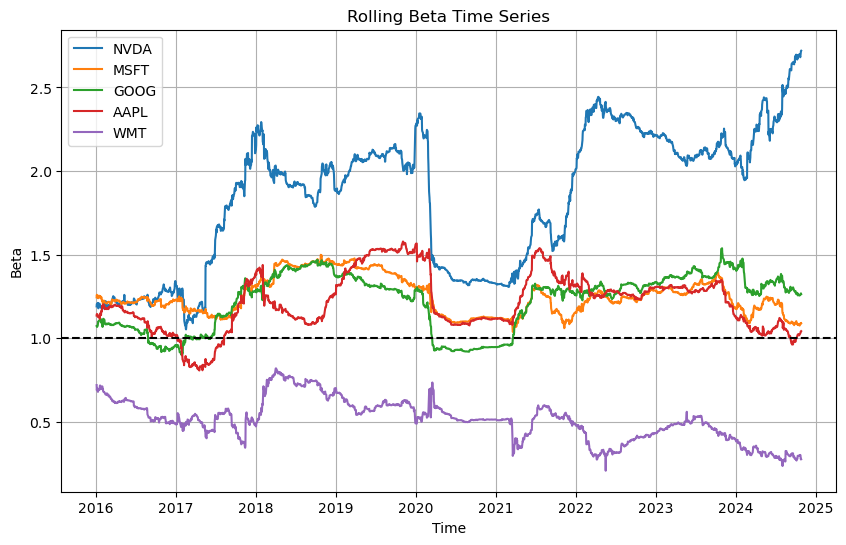

In [11]:
# Create Plot

tickers = ['NVDA', 'MSFT', 'GOOG', 'AAPL', 'WMT']

plt.figure(figsize=(10, 6))
plt.plot(betas_df[tickers], label=tickers, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Rolling Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()
plt.grid()

# Show
plt.show()

In [12]:
# Define the Decomposition Function
def betas_decomposition(
    target_df, 
    mktcap_df, 
    betas_df
):
    # Common Indexes
    common_index = target_df.index.intersection(betas_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    betas_df = betas_df.loc[common_index]

    # Initialize lists to store portfolio returns
    aggressive_list, neutral_list, defensive_list = [], [], []
    
    # Get unique quarters
    months = sorted(set([date.to_period('M') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    monthly_classifications = {}

    for month in months:
        # Select only the last available date of the quarter
        month_dates = [date for date in common_index if date.to_period('M') == month]
        rebalance_date = month_dates[-1]  # Last day of the quarter
        
        # Value factor (P/B ratio) for rebalance date
        betas_factor_df = pd.DataFrame([betas_df.loc[rebalance_date]], index=['beta']).T.dropna()
        
        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = betas_factor_df['beta'].quantile(0.3)
        upper = betas_factor_df['beta'].quantile(0.7)

        betas_factor_df['beta_class'] = 'neutral'
        betas_factor_df.loc[betas_factor_df['beta'] <= lower, 'beta_class'] = 'defensive'
        betas_factor_df.loc[betas_factor_df['beta'] >= upper, 'beta_class'] = 'aggressive'
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        defensive_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'defensive'].index]
        neutral_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'neutral'].index]
        aggressive_mktcap_df = market_caps_df.loc[betas_factor_df[betas_factor_df['beta_class'] == 'aggressive'].index]
        
        # Compute weights
        defensive_weights = defensive_mktcap_df['mkt_cap'] / defensive_mktcap_df['mkt_cap'].sum()
        neutral_weights = neutral_mktcap_df['mkt_cap'] / neutral_mktcap_df['mkt_cap'].sum()
        aggressive_weights = aggressive_mktcap_df['mkt_cap'] / aggressive_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        monthly_classifications[month] = {
            "defensive": defensive_weights,
            "neutral": neutral_weights,
            "aggressive": aggressive_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        month_key = date.to_period('M')  # Get quarter of the current date
        
        if month_key in monthly_classifications:
            # Retrieve stored classification and weights
            defensive_weights = monthly_classifications[month_key]["defensive"]
            neutral_weights = monthly_classifications[month_key]["neutral"]
            aggressive_weights = monthly_classifications[month_key]["aggressive"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            defensive_returns = target.reindex(defensive_weights.index).dropna()
            neutral_returns = target.reindex(neutral_weights.index).dropna()
            aggressive_returns = target.reindex(aggressive_weights.index).dropna()
            
            # Compute portfolio returns
            defensive_result = defensive_weights.reindex(defensive_returns.index).T @ defensive_returns
            neutral_result = neutral_weights.reindex(neutral_returns.index).T @ neutral_returns
            aggressive_result = aggressive_weights.reindex(aggressive_returns.index).T @ aggressive_returns
            
            # Store results
            defensive_list.append(defensive_result.values[0] if not defensive_result.empty else None)
            neutral_list.append(neutral_result.values[0] if not neutral_result.empty else None)
            aggressive_list.append(aggressive_result.values[0] if not aggressive_result.empty else None)

    # Create final DataFrame
    betas_portfolios = pd.DataFrame({
        'aggressive': aggressive_list,
        'neutral': neutral_list,
        'defensive': defensive_list
    }, index=common_index)
    
    return betas_portfolios

In [13]:
# Create DataFrames

betas_portfolios_returns = betas_decomposition(returns_df, mktcap_df, betas_df)

betas_portfolios_returns

,aggressive,neutral,defensive
2016-01-06,-0.025817,-0.014870,-0.005530
2016-01-07,-0.034651,-0.023391,-0.014471
2016-01-08,-0.015250,-0.011648,-0.006227
2016-01-11,-0.007952,-0.001033,0.001308
2016-01-12,0.005283,0.007669,0.003663
...,...,...,...
2024-10-21,-0.009274,-0.009817,-0.008058
2024-10-22,-0.007443,-0.004626,-0.001665
2024-10-23,-0.007670,-0.003600,0.001686
2024-10-24,0.006485,-0.002655,-0.001995


In [14]:
# Calculate the Analytics
beta_portfolios_analytics = calculate_analytics(betas_portfolios_returns)

beta_portfolios_analytics

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
aggressive,0.211779,0.271806,0.779154,-0.006116,-0.025757
neutral,0.150484,0.186903,0.805147,-0.004422,-0.017189
defensive,0.121138,0.132773,0.912365,-0.002718,-0.011779


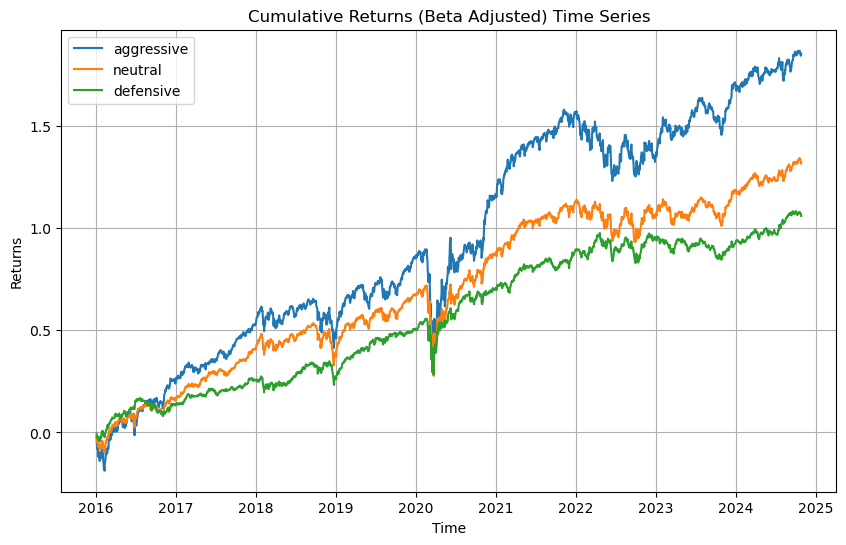

In [15]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_portfolios_returns.cumsum(), label=betas_portfolios_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Beta Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [17]:
# Create the data
daily_rfr = compute_daily_returns(rfr['risk_free_rate'])
market_excess_returns = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])

In [18]:
# Create the regression dataframe
beta_regression_df = pd.DataFrame(index = betas_portfolios_returns.index)

beta_regression_df['aggressive_excess_returns'] = betas_portfolios_returns['aggressive'] - daily_rfr
beta_regression_df['defensive_excess_returns'] = betas_portfolios_returns['defensive'] - daily_rfr
beta_regression_df['market_excess_returns'] = market_excess_returns
beta_regression_df.dropna(inplace = True)

beta_regression_df

,aggressive_excess_returns,defensive_excess_returns,market_excess_returns
2016-01-06,-0.025877,-0.005589,-0.013175
2016-01-07,-0.034710,-0.014531,-0.023760
2016-01-08,-0.015309,-0.006285,-0.010897
2016-01-11,-0.008012,0.001248,0.000794
2016-01-12,0.005225,0.003604,0.007745
...,...,...,...
2024-10-21,-0.009388,-0.008172,-0.001937
2024-10-22,-0.007557,-0.001779,-0.000589
2024-10-23,-0.007785,0.001570,-0.009307
2024-10-24,0.006370,-0.002109,0.002031


In [19]:
# Calculate the Beta for the Aggressive Portfolio

y = beta_regression_df['aggressive_excess_returns']
x = beta_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                                WLS Regression Results                               
Dep. Variable:     aggressive_excess_returns   R-squared:                       0.847
Model:                                   WLS   Adj. R-squared:                  0.847
Method:                        Least Squares   F-statistic:                 1.222e+04
Date:                       Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                               12:51:58   Log-Likelihood:                 7817.0
No. Observations:                       2202   AIC:                        -1.563e+04
Df Residuals:                           2200   BIC:                        -1.562e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [20]:
# Calculate the Beta for the Defensive Portfolio

y = beta_regression_df['defensive_excess_returns']
x = beta_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                               WLS Regression Results                               
Dep. Variable:     defensive_excess_returns   R-squared:                       0.600
Model:                                  WLS   Adj. R-squared:                  0.600
Method:                       Least Squares   F-statistic:                     3299.
Date:                      Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                              12:52:14   Log-Likelihood:                 8333.5
No. Observations:                      2202   AIC:                        -1.666e+04
Df Residuals:                          2200   BIC:                        -1.665e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [22]:
# Calculate the DMA Premium

beta_regression_df['BAB'] = betas_portfolios_returns['aggressive'] - betas_portfolios_returns['defensive']

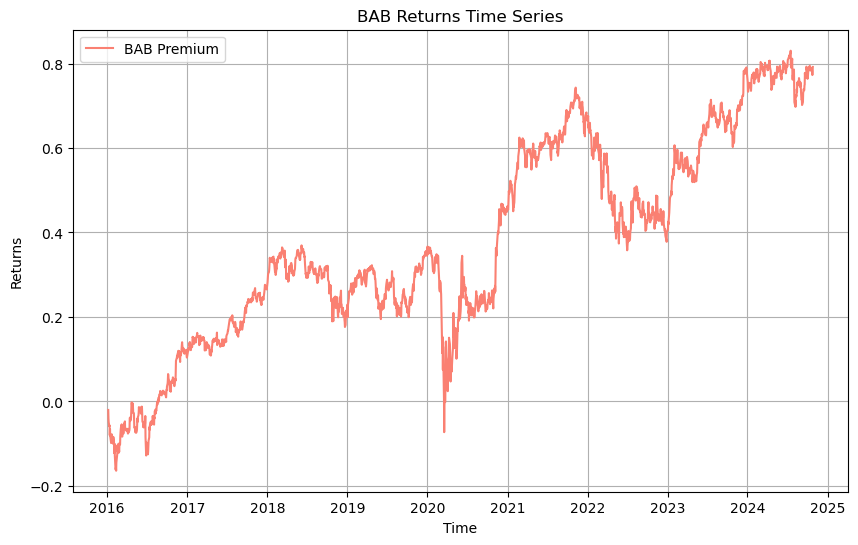

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(beta_regression_df['BAB'].cumsum(), label='BAB Premium', color = 'salmon', alpha=1)

# Config
plt.title('BAB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [24]:
# Check the Correlation with the Market

beta_regression_df['BAB'].corr(beta_regression_df['market_excess_returns'])

0.6876429627196867

In [25]:
# Calculate the Beta for the Defensive Portfolio
y = beta_regression_df['BAB']
x = beta_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                    BAB   R-squared:                       0.479
Model:                            WLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     2026.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          3.34e-314
Time:                        12:53:00   Log-Likelihood:                 7003.3
No. Observations:                2202   AIC:                        -1.400e+04
Df Residuals:                    2200   BIC:                        -1.399e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.143e-

In [27]:
# Store the Premium
beta_regression_df.index.name = "Date"
beta_regression_df['BAB'].to_csv(r"..\additional_data\carhart_bab.csv")